title: Premium churn - 2021  
author: Fabio Schmidt-Fischbach     
date: 2021-06-08     
region: EU    
link: https://docs.google.com/presentation/d/1aGl0VHzh7Z0Rywnw5DHhTCOWLJpVG3L03Y9K8p_b0bE/edit?usp=sharing   
tags: membership, churn, premium, retention, smart, you, metal, standard, mau   
summary: This analyses recent trends in premium churn and highlights key factors in the overall dynamics (market, tier, entry point, demographics, early user clusters). It also stresses the extent to which most of our churn is not softly downgraded to standard but instead has their accounts closed.   

In [1]:
from lifelines import CoxPHFitter
import pandas as pd
import altair as alt

In [ ]:
query = """

with age as ( 

select user_created, datediff('year', birth_date, current_date) as age from etl_reporting.cmd_users

), clusters as ( 

SELECT
    CASE
        WHEN early_cluster IN (
            'E01',
            'E02',
            'E03',
            'E04',
            'E05',
            'E06',
            'E12'
        ) THEN 'High Activity'
        WHEN early_cluster IN (
            'E07',
            'E08',
            'E09',
            'E10',
            'E11'
        ) THEN 'Low Activity'
    END as activity_group,
    CASE
        WHEN early_cluster = 'E01' THEN 'Spaces\nPower\nUsers'
        WHEN early_cluster = 'E02' THEN 'International\nTravelers'
        WHEN early_cluster = 'E03' THEN 'Euro\nTravelers'
        WHEN early_cluster = 'E04' THEN 'Cash26ers'
        WHEN early_cluster = 'E05' THEN 'Domestic\nSpenders'
        WHEN early_cluster = 'E06' THEN 'Mobile\nSpenders'
        WHEN early_cluster = 'E07' THEN 'Online\nSpenders'
        WHEN early_cluster = 'E08' THEN 'Barely\nActive'
        WHEN early_cluster = 'E09' THEN 'Cash\nSpenders'
        WHEN early_cluster = 'E10' THEN 'Holding\nAccount'
        WHEN early_cluster = 'E11' THEN 'Refer\nFriends'
        WHEN early_cluster = 'E12' THEN 'Primary\nAccount\nUsers'
    END AS early_cluster,
    user_id
from dwh_earlycluster_labels 

)

select user_id,
        tier, 
        case when market in ('DEU','ESP','ITA','FRA','AUT') then market else 'RoE' end as market, 
        age, 
        case when enter_reason = 'UPGRADED' then 1 else 0 end as is_upgrade, 
        is_expat,
        case when gender = 'FEMALE' then 1 else 0 end as is_female, 
        datediff('month', subscription_valid_from::date, least(current_date, subscription_valid_until::date)) as age, 
        subscription_valid_from, 
        subscription_valid_until,
        least(current_date, subscription_valid_until::date),
        case when subscription_valid_until > current_date then 0 else 1 end as churned,
        clusters.early_cluster,
        clusters.activity_group
from dbt.zrh_user_product
inner join age using (user_created) 
inner join dbt.zrh_users using (user_created)
left join clusters using (user_id)
where dbt.zrh_user_product.is_premium = True 
        and subscription_valid_from >= dateadd('month', -24, current_date)

"""

In [6]:
df = pd.read_csv("churn.csv")

df["market"] = df["market"].str.strip()

market = pd.get_dummies(df["market"])
tier = pd.get_dummies(df["tier"])
cluster = pd.get_dummies(df["early_cluster"])

df = df.merge(market, left_index=True, right_index=True).merge(
    tier, left_index=True, right_index=True
)
# df = df.merge(cluster,left_index=True, right_index=True, how="left")

cph = CoxPHFitter()  # sparse solutions,
cph.fit(
    df.drop(
        columns=[
            "user_id",
            "tier",
            "market",
            "DEU",
            "YOU",
            "early_cluster",
            "subscription_valid_from",
            "subscription_valid_until",
            "least",
            "activity_group",
        ]
    ),
    duration_col="churn_age",
    event_col="churned",
)

<lifelines.CoxPHFitter: fitted with 423937 total observations, 207346 right-censored observations>

In [132]:
df = pd.DataFrame(cph.hazard_ratios_).reset_index()

alt.Chart(
    df.loc[
        df["covariate"].isin(
            [
                "age",
                "FRA",
                "RoE",
                "AUT",
                "ESP",
                "ITA",
                "SMART",
                "METAL",
                "is_female",
                "is_expat",
                "is_upgrade",
                "age.1",
            ]
        )
        == False,
        :,
    ]
).mark_bar().encode(
    x=alt.X("covariate:N", sort="-y"),
    y=alt.Y("exp(coef):Q", axis=alt.Axis(title="Hazard ratio")),
).properties(
    width=500,
    height=500,
    title="How does premium churn differ across customer groups? Everything is relative to barely active users",
)

alt.Chart(...)

In [31]:
df = pd.DataFrame(cph.baseline_survival_).reset_index()

df.columns = ["age", "baseline survival"]

alt.Chart(df).mark_line().encode(
    x=alt.X("age:Q", axis=alt.Axis(title="Age in months")),
    y=alt.Y(
        "baseline survival:Q",
        axis=alt.Axis(format="%", title="% of original cohort retained"),
    ),
).properties(
    width=500,
    height=500,
    title="Baseline retention curve - last 2 years of premium cohorts",
)

alt.Chart(...)

In [29]:
df.head(15)

,age,baseline survival
0,0.0,0.948556
1,1.0,0.910305
2,2.0,0.865227
3,3.0,0.735910
4,4.0,0.682413
5,5.0,0.630060
6,6.0,0.586791
7,7.0,0.554026
8,8.0,0.526575
9,9.0,0.502345


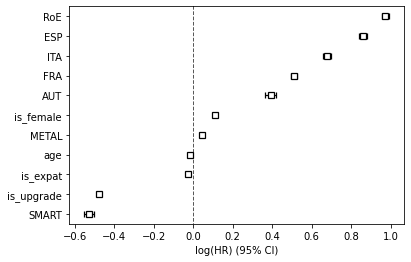

In [7]:
cph.plot()

In [125]:
cph.print_summary()

<lifelines.CoxPHFitter: fitted with 423937 total observations, 207346 right-censored observations>
             duration col = 'churn_age'
                event col = 'churned'
      baseline estimation = breslow
   number of observations = 423937
number of events observed = 216591
   partial log-likelihood = -2628357.13
         time fit was run = 2021-05-25 13:00:13 UTC

---
                           coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                        
age                       -0.02       0.98       0.00            -0.02            -0.02                 0.98                 0.98
is_upgrade                -0.47       0.62       0.01            -0.48            -0.46                 0.62                 0.63
is_expat                  -0.03       0.97       0.01            -0.04            -0.02                 0.96                 0.98
is_female                  0.11       1.12       0.00             0.10             0.12                 1.11                 1.13
AUT                        0.39       1.47       0.02             0.36             0.42                 1.43                 1.52
ESP                        0.86       2.36       0.01             0.84             0.88                 2.31                 2.41
FRA                        0.51       1.66       0.01             0.49             0.52                 1.64                 1.69
ITA                        0.67       1.96       0.01             0.65             0.69                 1.92                 2.00
RoE                        0.97       2.63       0.01             0.95             0.99                 2.59                 2.68
METAL                      0.04       1.04       0.00             0.03             0.05                 1.03                 1.05
SMART                     -0.54       0.58       0.01            -0.56            -0.52                 0.57                 0.60
Cash\nSpenders            -0.10       0.90       0.03            -0.15            -0.05                 0.86                 0.95
Cash26ers                 -0.20       0.82       0.07            -0.35            -0.06                 0.71                 0.94
Domestic\nSpenders        -0.54       0.58       0.02            -0.57            -0.50                 0.57                 0.60
Euro\nTravelers           -0.60       0.55       0.04            -0.68            -0.53                 0.51                 0.59
Holding\nAccount          -0.23       0.79       0.02            -0.27            -0.19                 0.76                 0.82
International\nTravelers  -0.64       0.53       0.04            -0.71            -0.57                 0.49                 0.57
Mobile\nSpenders          -0.55       0.58       0.03            -0.61            -0.48                 0.54                 0.62
Online\nSpenders          -0.32       0.73       0.03            -0.39            -0.25                 0.68                 0.78
Primary\nAccount\nUsers   -0.76       0.47       0.09            -0.94            -0.58                 0.39                 0.56
Refer\nFriends            -0.14       0.87       0.12            -0.37             0.10                 0.69                 1.10
Spaces\nPower\nUsers      -0.66       0.52       0.03            -0.71            -0.60                 0.49                 0.55

                              z      p   -log2(p)
covariate                                        
age                      -89.50 <0.005        inf
is_upgrade               -88.87 <0.005        inf
is_expat                  -4.94 <0.005      20.27
is_female                 23.63 <0.005     407.79
AUT                       25.50 <0.005     473.89
ESP                       77.80 <0.005        inf
FRA                       64.97 <0.005        inf
ITA                       64.48 <0.005        inf

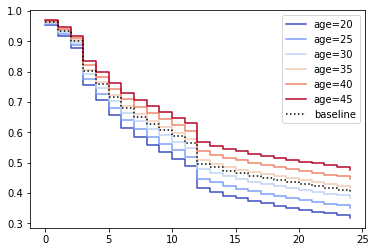

In [33]:
cph.plot_partial_effects_on_outcome(
    covariates="age", values=[20, 25, 30, 35, 40, 45], cmap="coolwarm"
)

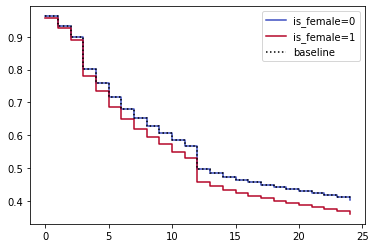

In [35]:
cph.plot_partial_effects_on_outcome(
    covariates="is_female", values=[0, 1], cmap="coolwarm"
)

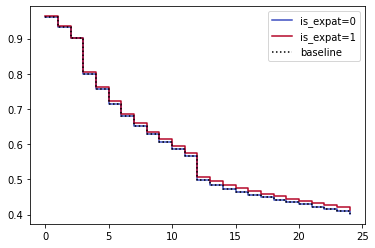

In [36]:
cph.plot_partial_effects_on_outcome(
    covariates="is_expat", values=[0, 1], cmap="coolwarm"
)

## by market 

In [11]:
df = pd.read_csv("churn.csv")

tier = pd.get_dummies(df["tier"])

tier.head()

,METAL,SMART,YOU
0,0,0,1
1,0,1,0
2,1,0,0
3,1,0,0
4,0,1,0


In [29]:
def get_churn_results(market, df):
    """
    Pull coefs for clusters by market
    """

    df["market"] = df["market"].str.strip()
    df = df.loc[df["market"] == market, :]

    tier = pd.get_dummies(df["tier"])
    cluster = pd.get_dummies(df["early_cluster"])

    df = df.merge(tier, left_index=True, right_index=True)
    df = df.merge(cluster, left_index=True, right_index=True, how="inner")

    cph = CoxPHFitter()  # sparse solutions,
    cph.fit(
        df.drop(
            columns=[
                "user_id",
                "tier",
                "market",
                "YOU",
                "early_cluster",
                "subscription_valid_from",
                "subscription_valid_until",
                "least",
                "activity_group",
                "Barely\nActive",
            ]
        ),
        duration_col="churn_age",
        event_col="churned",
    )

    df = pd.DataFrame(cph.hazard_ratios_).reset_index()
    df["market"] = market

    return df


df = pd.read_csv("churn.csv")

results = pd.DataFrame()
for market in ["DEU", "ESP", "ITA", "FRA", "AUT", "RoE"]:
    results = results.append(get_churn_results(market, df))


results["exp(coef)"] = round(results["exp(coef)"], 1)


base = (
    alt.Chart(
        results.loc[
            results["covariate"].isin(
                [
                    "age",
                    "FRA",
                    "RoE",
                    "AUT",
                    "ESP",
                    "ITA",
                    "SMART",
                    "METAL",
                    "is_female",
                    "is_expat",
                    "is_upgrade",
                    "age.1",
                ]
            )
            == False,
            :,
        ]
    )
    .encode(
        alt.X("covariate:N", scale=alt.Scale(paddingInner=0)),
        alt.Y("market:N", scale=alt.Scale(paddingInner=0)),
    )
    .properties(width=500, height=500)
)

# Configure heatmap
heatmap = base.mark_rect().encode(
    color=alt.Color(
        "exp(coef):Q",
        scale=alt.Scale(scheme="viridis"),
        legend=alt.Legend(direction="horizontal"),
    )
)

# Configure text
text = base.mark_text(baseline="middle").encode(
    text="exp(coef):Q",
)

# Draw the chart
heatmap + text

/Users/fabioschmidt-fischbach/anaconda3/lib/python3.7/site-packages/lifelines/utils/__init__.py:1090: ConvergenceWarning: Column(s) ['Cash26ers'] have very low variance. This may harm convergence. 1) Are you using formula's? Did you mean to add '-1' to the end. 2) Try dropping this redundant column before fitting if convergence fails.

  warnings.warn(dedent(warning_text), ConvergenceWarning)


alt.LayerChart(...)

In [19]:
df = pd.read_csv("churn.csv")

df = df.loc[df["early_cluster"].isna() == False, :]
df["market"] = df["market"].str.strip()

##keep at least 1 year old cohorts
df = df.loc[
    pd.to_datetime(df["subscription_valid_from"]) <= pd.to_datetime("2020-01-01"), :
]
df["month"] = pd.to_datetime(df["subscription_valid_from"]).dt.to_period("M")

df = df.loc[
    :,
    [
        "early_cluster",
        "activity_group",
        "user_id",
        "churn_age",
        "market",
        "churned",
        "month",
    ],
]
df["key"] = 1

helper = pd.DataFrame(df["churn_age"].unique(), columns=["running_month"])
helper["key"] = 1
# join helper table
df = df.merge(helper, on=["key"])

df = df.loc[df["running_month"] <= df["churn_age"], :]

df = (
    df.groupby(["early_cluster", "activity_group", "month", "running_month"])["user_id"]
    .agg("nunique")
    .reset_index()
)

x = (
    df.loc[df["running_month"] == 0, :]
    .groupby(["month"])["user_id"]
    .agg("sum")
    .reset_index()
)
x.columns = ["month", "total"]
df = df.merge(x, on="month")

df["perc"] = 100 * df["user_id"] / df["total"]

df = (
    df.groupby(["running_month", "activity_group", "early_cluster"])["perc"]
    .agg("mean")
    .reset_index()
)

alt.Chart(
    df.loc[(df["running_month"] <= 24) & (df["activity_group"] == "High Activity"), :]
).mark_line().encode(
    x=alt.X("running_month:Q", axis=alt.Axis(title="Months since joining")),
    y=alt.Y("sum(perc):Q", axis=alt.Axis(title="% of original cohort size retained")),
    color=alt.Color("early_cluster:N", scale=alt.Scale(scheme="tableau20")),
).properties(
    width=400, height=400, title="% of original cohort size retained (high activity)"
)

alt.Chart(...)

In [14]:
df = pd.read_csv("churn.csv")

df = df.loc[df["early_cluster"].isna() == False, :]
df["market"] = df["market"].str.strip()

##keep at least 1 year old cohorts
df = df.loc[
    pd.to_datetime(df["subscription_valid_from"]) <= pd.to_datetime("2020-01-01"), :
]
df["month"] = pd.to_datetime(df["subscription_valid_from"]).dt.to_period("M")

df = df.loc[
    :,
    [
        "early_cluster",
        "activity_group",
        "user_id",
        "churn_age",
        "market",
        "churned",
        "month",
    ],
]
df["key"] = 1

helper = pd.DataFrame(df["churn_age"].unique(), columns=["running_month"])
helper["key"] = 1
# join helper table
df = df.merge(helper, on=["key"])

df = df.loc[df["running_month"] <= df["churn_age"], :]

df = (
    df.groupby(["early_cluster", "activity_group", "month", "running_month"])["user_id"]
    .agg("nunique")
    .reset_index()
)

x = (
    df.loc[df["running_month"] == 0, :]
    .groupby(["month"])["user_id"]
    .agg("sum")
    .reset_index()
)
x.columns = ["month", "total"]
df = df.merge(x, on="month")

df["perc"] = 100 * df["user_id"] / df["total"]

df = (
    df.groupby(["running_month", "activity_group", "early_cluster"])["perc"]
    .agg("mean")
    .reset_index()
)

alt.Chart(df).mark_bar().encode(
    x=alt.X("running_month:Q", axis=alt.Axis(title="Months since joining")),
    y=alt.Y("sum(perc):Q", axis=alt.Axis(title="% of original cohort size retained")),
    color=alt.Color("early_cluster:N", scale=alt.Scale(scheme="tableau20")),
    column="activity_group:N",
).properties(width=500, height=500, title="% of original cohort size retained")

alt.Chart(...)

In [7]:
df.head()

,running_month,activity_group,early_cluster,perc
0,0,High Activity,Cash26ers,1.343362
1,0,High Activity,Domestic\nSpenders,26.493977
2,0,High Activity,Euro\nTravelers,5.750237
3,0,High Activity,International\nTravelers,7.338632
4,0,High Activity,Mobile\nSpenders,4.962141


In [21]:
df = pd.read_csv("churn.csv")

df = df.loc[df["early_cluster"].isna() == False, :]
df["market"] = df["market"].str.strip()

##keep at least 1 year old cohorts
df = df.loc[
    pd.to_datetime(df["subscription_valid_from"]) <= pd.to_datetime("2020-01-01"), :
]
df["month"] = pd.to_datetime(df["subscription_valid_from"]).dt.to_period("M")

df = df.loc[
    :,
    [
        "early_cluster",
        "user_id",
        "churn_age",
        "market",
        "churned",
        "month",
        "activity_group",
    ],
]
df["key"] = 1

helper = pd.DataFrame(df["churn_age"].unique(), columns=["running_month"])
helper["key"] = 1
# join helper table
df = df.merge(helper, on=["key"])

df = df.loc[df["running_month"] <= df["churn_age"], :]

df = (
    df.groupby(["early_cluster", "month", "activity_group", "running_month"])["user_id"]
    .agg("nunique")
    .reset_index()
)

x = (
    df.loc[df["running_month"] == 0, :]
    .groupby(["month", "activity_group", "early_cluster"])["user_id"]
    .agg("sum")
    .reset_index()
)
x.columns = ["month", "activity_group", "early_cluster", "total"]
df = df.merge(x, on=["month", "activity_group", "early_cluster"])

df["perc"] = 100 * df["user_id"] / df["total"]

df = (
    df.groupby(["running_month", "activity_group", "early_cluster"])["perc"]
    .agg("mean")
    .reset_index()
)

alt.Chart(
    df.loc[(df["running_month"] <= 24) & (df["activity_group"] == "High Activity"), :]
).mark_line().encode(
    x=alt.X("running_month:Q", axis=alt.Axis(title="Months since joining")),
    y=alt.Y("sum(perc):Q", axis=alt.Axis(title="% of cluster retained")),
    color=alt.Color("early_cluster:N", scale=alt.Scale(scheme="tableau20")),
).properties(
    width=300, height=300, title="% of cluster retained (high activity)"
)

alt.Chart(...)

In [23]:
df = pd.read_csv("churn.csv")

df = df.loc[df["early_cluster"].isna() == False, :]
df["market"] = df["market"].str.strip()

##keep at least 1 year old cohorts
df = df.loc[
    pd.to_datetime(df["subscription_valid_from"]) <= pd.to_datetime("2020-01-01"), :
]
df["month"] = pd.to_datetime(df["subscription_valid_from"]).dt.to_period("M")

df = df.loc[
    :,
    [
        "early_cluster",
        "user_id",
        "churn_age",
        "market",
        "churned",
        "month",
        "activity_group",
    ],
]
df["key"] = 1

helper = pd.DataFrame(df["churn_age"].unique(), columns=["running_month"])
helper["key"] = 1
# join helper table
df = df.merge(helper, on=["key"])

df = df.loc[df["running_month"] <= df["churn_age"], :]

df = (
    df.groupby(["early_cluster", "month", "activity_group", "running_month"])["user_id"]
    .agg("nunique")
    .reset_index()
)

x = (
    df.loc[df["running_month"] == 0, :]
    .groupby(["month", "activity_group", "early_cluster"])["user_id"]
    .agg("sum")
    .reset_index()
)
x.columns = ["month", "activity_group", "early_cluster", "total"]
df = df.merge(x, on=["month", "activity_group", "early_cluster"])

df["perc"] = 100 * df["user_id"] / df["total"]

df = (
    df.groupby(["running_month", "activity_group", "early_cluster"])["perc"]
    .agg("mean")
    .reset_index()
)

alt.Chart(
    df.loc[(df["running_month"] <= 24) & (df["activity_group"] != "High Activity"), :]
).mark_line().encode(
    x=alt.X("running_month:Q", axis=alt.Axis(title="Months since joining")),
    y=alt.Y("sum(perc):Q", axis=alt.Axis(title="% of cluster retained")),
    color=alt.Color("early_cluster:N", scale=alt.Scale(scheme="tableau20")),
).properties(
    width=300, height=300, title="% of cluster retained (low activity)"
)

alt.Chart(...)